### Quora Insincere Questions: Latent Dirichlet allocation (LDA)

Latent dirichlet allocation (LDA) is a generative statistical model to classify documents based on topics that the model identified in the corpus. It follows the idea that each document that each document consists of a mix of a small number of topics and that each word's presence is attributable to one of the document's topics. 

In this notebook, I perform LDA on the training data with 2 topics to see if the generated topics might be helpful in identifying regular vs insincere questions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.corpora.dictionary import Dictionary
from gensim.parsing.preprocessing import remove_stopwords
from pylab import rcParams
from gensim.models.ldamodel import LdaModel
import os
os.chdir('/home/roman/Documents/Projects/Quora/data')

In [2]:
# load and prepare data:
train_data = pd.read_csv('train.csv')
docs_df = train_data['question_text']
# remove stopwords words and tokenize:
docs_df = docs_df.apply(remove_stopwords)
docs_list = docs_df.tolist()
# take out frequent words with no meaning (from exploratory analysis)
freq_word_list = ['what', 'i', 'how', 'why', 'is', 'can', 'do', 'like','which', \
                  'if', 'are', 'think', 'does', 'who', 'use', 'way', 'know', 'where',\
                  'want', 'it', 'should', 'when', "what's", "don't", "i'm", 'in']
texts = [[word for word in document.lower().replace("?", "").split() 
         if word not in freq_word_list] for document in docs_list]

In [3]:
# create dictionary and train LDA model:
dct = Dictionary(texts)
corpus = [dct.doc2bow(text) for text in texts]
lda = LdaModel(corpus, num_topics=2, id2word=dct)

In [4]:
# Evaluate LDA topics
for idx, topic in lda.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.012*"people" + 0.005*"time" + 0.005*"life" + 0.004*"feel" + 0.004*"person" + 0.004*"good" + 0.003*"year" + 0.003*"mean" + 0.003*"years" + 0.003*"women"
Topic: 1 
Words: 0.015*"best" + 0.007*"india" + 0.006*"good" + 0.004*"quora" + 0.003*"work" + 0.003*"difference" + 0.003*"new" + 0.003*"job" + 0.003*"us" + 0.003*"learn"


The topic analysis above shows which words contribute how much to the LDA classification to either topic (0 or 1). Looking at the words, and keeping the most frequent words from "exploration.ipynb" in mind, it is not obvious that either one of the topics is more likely associated with insincere questions than the other.

In [5]:
# Add a column for topic to data frame:
topic = []
for text in corpus:
    if lda[text][0][1] > 0.5:
        topic.append(0)
    else:
        topic.append(1)
train_data['topic'] = topic

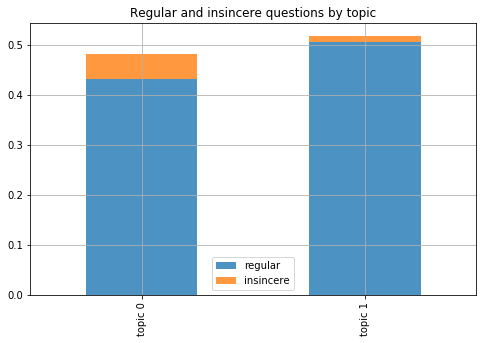

In [6]:
# Plot distribution of topic by regular vs insincere questions:
topic0_regular = sum(np.logical_and(train_data['target']==0, train_data['topic']==0))\
    / train_data.shape[0]
topic0_insincere = sum(np.logical_and(train_data['target']==1, train_data['topic']==0))\
    / train_data.shape[0]
topic1_regular = sum(np.logical_and(train_data['target']==0, train_data['topic']==1))\
    / train_data.shape[0]
topic1_insincere = sum(np.logical_and(train_data['target']==1, train_data['topic']==1))\
    / train_data.shape[0]
df = pd.DataFrame(np.array([[topic0_regular, topic0_insincere], [topic1_regular, topic1_insincere]]),\
               columns=['regular', 'insincere'], index=['topic 0', 'topic 1'])
rcParams['figure.figsize'] = 8, 5
df.plot.bar(stacked=True, alpha=0.8)
plt.grid()
plt.title('Regular and insincere questions by topic')
plt.show()

The plot above shows that LDA classified the majority of insincere questions as "topic 0". However, the topics 0 and 1 do not clearly separate regular from insincere questions as we are dealing with an inbalanced dataset and LDA splits the dataset into two classes of roughly equal size.